# EPS, Book Value and Returns

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

sns.set_context('notebook')
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (12,5)

In [2]:
from arctic import Arctic

store = Arctic('localhost')
report = store['reports']
prices = store['prices']

In [3]:
symbols = prices.list_symbols()

In [56]:
def returns(symbol, start):
    """return the simple interest of a symbol in 1 year
       
       start: str/timestamp, the starting date
    """
    start = pd.to_datetime(start)
    end = start + timedelta(365)
    p = prices.read(symbol).data[start:end]
    r = (p['close'].ix[-1] - p['close'].ix[0]) / p['close'].ix[0]
    
    return r
    

In [6]:
symbol = '000625'

In [7]:
returns(symbol, '2010-1-1')

-33.984329769578146

In [9]:
# now get the eps, book values in annual reports
data = report.read(symbol).data
data = data[['eps', 'net_asset', 'type']]

In [15]:
mask = data.type.map(lambda x: '12-31' in x)

In [29]:
annual = data[mask].copy()

In [30]:
annual

,eps,net_asset,type
report_date,,,
1998-04-22,0.228385,2.762193,1997-12-31
1999-04-26,0.013510,1.908323,1998-12-31
2000-04-20,0.043789,1.934993,1999-12-31
2001-04-11,0.120371,2.005950,2000-12-31
2002-03-11,0.130611,2.098624,2001-12-31
2003-04-08,0.680705,2.691330,2002-12-31
2004-03-18,1.182616,3.863136,2003-12-31
2005-04-15,0.812722,4.304814,2004-12-31
2006-04-15,0.146066,4.153204,2005-12-31


In [57]:
# then compute the returns
annual['returns'] = annual.index.map(lambda x: returns(symbol, x))

In [58]:
annual

,eps,net_asset,type,returns
report_date,,,,
1998-04-22,0.228385,2.762193,1997-12-31,-0.276463
1999-04-26,0.013510,1.908323,1998-12-31,0.092636
2000-04-20,0.043789,1.934993,1999-12-31,0.428592
2001-04-11,0.120371,2.005950,2000-12-31,-0.263011
2002-03-11,0.130611,2.098624,2001-12-31,0.759296
2003-04-08,0.680705,2.691330,2002-12-31,0.278222
2004-03-18,1.182616,3.863136,2003-12-31,-0.609482
2005-04-15,0.812722,4.304814,2004-12-31,0.221441
2006-04-15,0.146066,4.153204,2005-12-31,2.248739


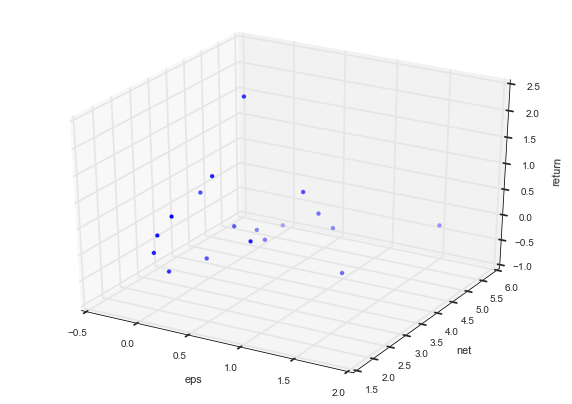

In [59]:
# see what's look like
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

ax.scatter(annual['eps'], annual['net_asset'], annual['returns'])
ax.set_xlabel('eps')
ax.set_ylabel('net')
ax.set_zlabel('return')
ax.legend()

In [60]:
# linear regression

from scipy import stats
import statsmodels.formula.api as sm

X = annual[['eps', 'net_asset']]
Y = annual['returns']

In [61]:
result = sm.OLS( Y, X ).fit()

In [102]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     4.077
Date:                Thu, 30 Jul 2015   Prob (F-statistic):             0.0371
Time:                        15:18:05   Log-Likelihood:                -15.697
No. Observations:                  18   AIC:                             35.39
Df Residuals:                      16   BIC:                             37.17
Df Model:                           2                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
eps           -0.9881      0.424     -2.332      0.033        -1.886    -0.090
net_asset      0.2143      0.075      2.853      0.012         0.055     0.374
==============================================================================
Omnibus:                        3.810   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                2.079
Skew:                           0.813   Prob(JB):                        0.354
Kurtosis:                       3.355   Cond. No.                         10.7
==============================================================================
"""

In [103]:
result.params # seems not a good fit..

eps         -0.988087
net_asset    0.214307
dtype: float64

In [100]:
# the regressed surface
X = np.arange(-1, 6, 0.5)
Y = np.arange(-1, 6, 0.5)
X, Y = np.meshgrid(X, Y)
Z = result.params[0] * X + result.params[1] * Y

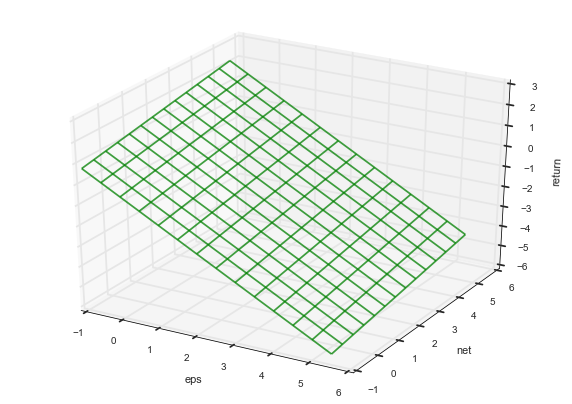

In [104]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, alpha=.75, color='g')
#ax.scatter(annual['eps'], annual['net_asset'], annual['returns'])
ax.set_xlabel('eps')
ax.set_ylabel('net')
ax.set_zlabel('return')

In [83]:
X[0]

array([-1.        , -0.81578947, -0.63157895, -0.44736842, -0.26315789,
       -0.07894737,  0.10526316,  0.28947368,  0.47368421,  0.65789474,
        0.84210526,  1.02631579,  1.21052632,  1.39473684,  1.57894737,
        1.76315789,  1.94736842,  2.13157895,  2.31578947,  2.5       ])